In [1]:
import pandas as pd
df=pd.read_csv('../input/movielens/ratings.csv')
print(df)

          userId  movieId  rating   timestamp
0              1      307     3.5  1256677221
1              1      481     3.5  1256677456
2              1     1091     1.5  1256677471
3              1     1257     4.5  1256677460
4              1     1449     4.5  1256677264
...          ...      ...     ...         ...
27753439  283228     8542     4.5  1379882795
27753440  283228     8712     4.5  1379882751
27753441  283228    34405     4.5  1379882889
27753442  283228    44761     4.5  1354159524
27753443  283228    54286     4.5  1354159718

[27753444 rows x 4 columns]


In [2]:
print(df.nunique(axis = 0))

userId         283228
movieId         53889
rating             10
timestamp    22131556
dtype: int64


<AxesSubplot:>

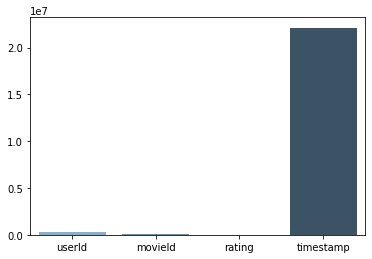

In [3]:
import seaborn as sns
sns.barplot(x=df.columns, y=df.nunique(axis=0), palette="Blues_d")

<AxesSubplot:ylabel='Frequency'>

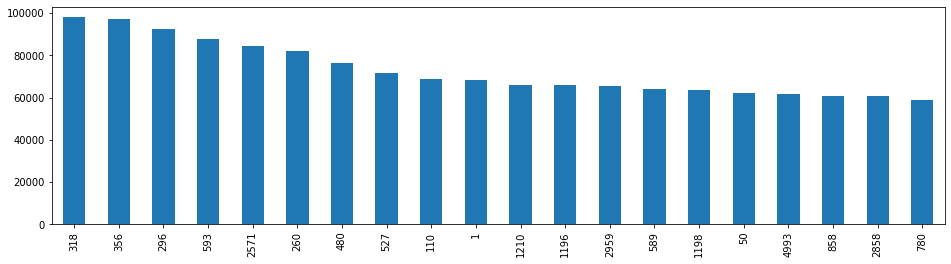

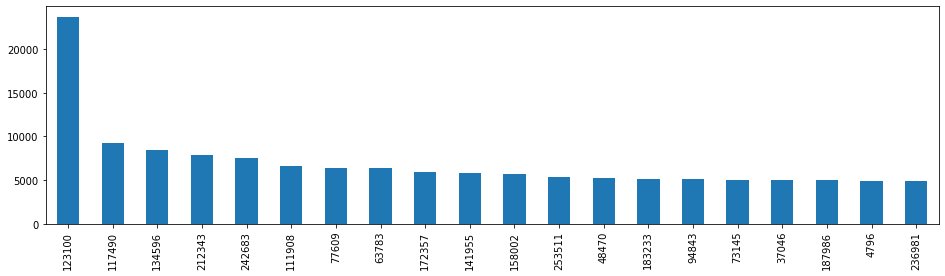

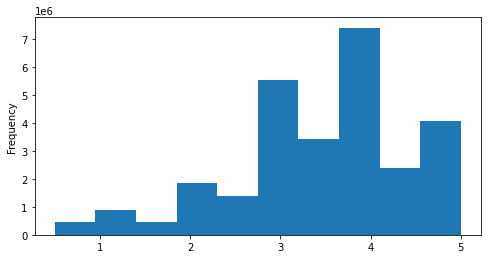

In [4]:
# univariate analysis
import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,4))
#top 20 movies
df['movieId'].value_counts()[:20].plot(kind = 'bar') 
plt.figure(2, figsize = (16,4))
#top 20 users
df['userId'].value_counts()[:20].plot(kind = 'bar') 
plt.figure(3, figsize = (8,4))
df['rating'].plot(kind = 'hist')

<AxesSubplot:>

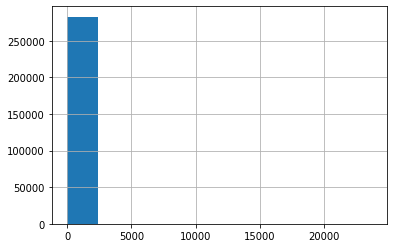

In [5]:
ratings_per_user = df.groupby('userId')['movieId'].count()
ratings_per_user.hist()

<AxesSubplot:>

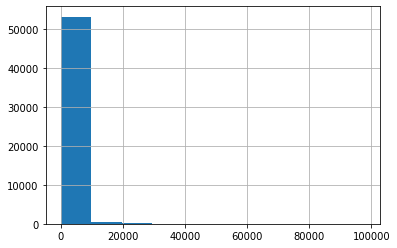

In [6]:
ratings_per_movie = df.groupby('movieId')['userId'].count()
ratings_per_movie.hist()

In [7]:
import surprise
from surprise import SVD
# SVD
SVD_algo = SVD()

In [8]:
from surprise import Dataset
from surprise import Reader
# load dataframe into Surprise Reader object
reader = Reader(rating_scale = (0,5))
rating_dataframe = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

In [9]:
from surprise.model_selection import train_test_split
from surprise import accuracy
# define train test function
def train_test_algo(algo, label):
    training_set, testing_set = train_test_split(rating_dataframe, test_size = 0.25)
    algo.fit(training_set)
    test_output = algo.test(testing_set)
    test_dataframe = pd.DataFrame(test_output)
    print("RMSE -",label, accuracy.rmse(test_output, verbose = False))
    print("MAE -", label, accuracy.mae(test_output, verbose=False))
    print("MSE -", label, accuracy.mse(test_output, verbose=False))
    
    return test_dataframe

In [10]:
train_test_SVD = train_test_algo(SVD_algo, "SVD_algo")
print(train_test_SVD.head())

RMSE - SVD_algo 0.7979897029603923
MAE - SVD_algo 0.6025927732135373
MSE - SVD_algo 0.6367875660308151
      uid     iid  r_ui       est                    details
0   39569   59107   2.0  2.652985  {'was_impossible': False}
1  135415   59784   2.5  3.090653  {'was_impossible': False}
2  180345   36529   5.0  4.189357  {'was_impossible': False}
3  103615   45728   3.5  2.758480  {'was_impossible': False}
4  237509  133281   3.0  3.443806  {'was_impossible': False}


In [11]:
movie_dataframe = pd.read_csv("../input/movielens/movies.csv")
links_dataframe = pd.read_csv("../input/movielens/links.csv")

In [12]:
def prediction(algo, users_K):
    prediction_list = []
    for userId in range(1,users_K):
        for movieId in range(1,53889):
            rating = algo.predict(userId, movieId).est
            prediction_list.append([userId, movieId, rating])
    prediction_dataframe = pd.DataFrame(prediction_list, columns = ['userId', 'movieId', 'rating'])
    return prediction_dataframe

In [13]:
def top_recommendations_movies(prediction_dataframe, top_N):
    link_movie = pd.merge(prediction_dataframe, links_dataframe, how='inner', left_on='movieId', right_on='movieId')
    rec_movie = pd.merge(link_movie, movie_dataframe, how='left', left_on='movieId', right_on='movieId')[['userId', 'movieId', 'rating','imdbId','title']]
    sorted_df = rec_movie.groupby(('userId'), as_index = False).apply(lambda x: x.sort_values(['rating'], ascending = False)).reset_index(drop=True)
    top_rec_movies = sorted_df.groupby('userId').head(top_N)
    return sorted_df, top_rec_movies

In [14]:
## SVD predictions for the MovieLens Large Dataset
pred_SVD = prediction(SVD_algo, 6)
rec_movies_SVD, top_rec_movies_SVD = top_recommendations_movies(pred_SVD, 3)
print('\n')
print('\n')
print("Top Three Movies Recommendations for first 5 users")
print(top_rec_movies_SVD)





Top Three Movies Recommendations for first 5 users
       userId  movieId    rating  imdbId  \
0           1     7560  4.598839   58083   
1           1     5618  4.524845  245429   
2           1    26340  4.522552   72901   
11986       2      318  4.570020  111161   
11987       2       62  4.513731  113862   
11988       2     7153  4.507314  167260   
23972       3     5618  4.715050  245429   
23973       3     5971  4.582767   96283   
23974       3      858  4.569180   68646   
35958       4     3578  5.000000  172495   
35959       4     5952  5.000000  167261   
35960       4    51662  5.000000  416449   
47944       5     2858  4.844103  169547   
47945       5      296  4.841094  110912   
47946       5     2324  4.801865  118799   

                                                   title  
0                                       Fail-Safe (1964)  
1      Spirited Away (Sen to Chihiro no kamikakushi) ...  
2      Twelve Tasks of Asterix, The (Les douze travau...  
1198